# Capstone Project - Lifestyle Aspects Analysis of the Cities in Two Different Geographical Locations
### Applied Data Science Capstone by IBM/Coursera

## 1. Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## 2. Introduction <a name="introduction"></a>

In this final capstone project I will try to find several locations in two different cities based on specified criteria.

This analysis is suitable for the situation, when person needs to move from city A to city B and parallelly wants to keep its living habits. Main goal is then to find districts, suburbs or boroughs in each city with mutually similar characteristics. Some of the cities presented in this analysis are intentionally chosen from different geographical environments and hasn't the same size of population. Intention is to find out if those aspects has significant impact on amount of resulting locations. Analyzed cities are following:
 * Prague - capital of Czech Republic with population of 1,3 mil. (2019) located in central Europe and founded in 8th century AD.
 * Sydney - city of Australia with population of 4,6 mil. (2011) located in New South Wales and founded in 18th century AD.

Conditions which all places has to meet are defined based on individual preference. Idea is to maintain healthy lifestyle, minimize time necessary for routine activities like traveling to job or shopping and dedicate it more to fitness activities in gyms or parks or spend more time on cultural events. 

Based on that, targeted location should be covered by dense net of public transport. It should include shopping malls not far located and also parks and gyms approachable within several minutes of walking.

With help of Foursquare platform geolocation data and data science approaches, we will get as a result list of appropriate locations for each city with mutual comparison. 

## 3. Data <a name="data"></a>

Inputs used in this type of study falls into three categories. 

As a first step, its necessary to obtain list of districts or neighborhoods of particular city. Goal is to get at least 100 locations for analysis across the city as input. In case of Prague, list of Prague districts is sufficient. List of inner suburbs is used in case of Sydney.

Next type of data are coordinates assigned to each address from the lists of suburbs or districts by GeoPy. This is used as input for function localazing venues at Foursquare.  Last category is then Foursquare location data filtered according definition of the problem like public transport stations, shopping plazas, pharmacies and parks. Venues located in each district or suburb are then used for further processing and evaluation.

## 4. Methodology <a name="methodology"></a>

Methodology scheme is very simple and for analyzing each city it's applied in same the way.

First part is focused on import districts/suburbs data their update in way, that they are possible to visualize on Folium map. This leads to second step where city districts/suburbs are extended about venues data via Foursquare API according defined conditions and prepared for clustering process. Third part is focused on usage of K-Means algorithm, therefore finding of the best k parameter is done and then all venues are clustered. Finally, last step is focusing on extraction of districts/suburbs from clusters which are matching the best to defined criteria.

For detailed commentary on methodology, please move forward to analysis section below. There you can find further explanation of each step done in analysis and factors which leads to that. This is done completely for Prague city analysis. Due to fact that overall methodology is always the same, for Sydney are commented only steps which differentiate from method applied in case of Prague.

## 5. Analysis

In [330]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import matplotlib.pyplot as plt 

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library


from sklearn.cluster import KMeans # import k-means from clustering stage


import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported.


In [331]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


### 5.1 Prague - Czech Republic

#### Dataset Import and Modification

As a first step, we need to create dataset containing names of the Prague districts. This is done by importing of the excel file into pandas dataframe. In early stages of the script creation It was discovered that Nominatim module converts full district addresses with less error than name of the district only, therefore columns of "City" and "Country" were added into xlsx file before import into dataframe. 

In [332]:
PragueDistricts = pd.read_excel('prague_districts_v01.xlsx') # read the excel file
PragueDistricts

,Prague District,City,Country
0,Stodůlky,Prague,Czech Republic
1,Žižkov,Prague,Czech Republic
2,Chodov,Prague,Czech Republic
3,Vinohrady,Prague,Czech Republic
4,Vršovice,Prague,Czech Republic
...,...,...,...
107,Lahovice,Prague,Czech Republic
108,Nedvězí u Říčan,Prague,Czech Republic
109,Lipany,Prague,Czech Republic
110,Malá Chuchle,Prague,Czech Republic


Now, we extend Prague districts dataframe about the new column "Address" by merging data from previous three columns into the one.

In [333]:
PragueDistricts["Address"] = PragueDistricts["Prague District"]+", "+ PragueDistricts["City"] +", "+ PragueDistricts["Country"] # merge columns and add Address column
PragueDistricts.head()

,Prague District,City,Country,Address
0,Stodůlky,Prague,Czech Republic,"Stodůlky, Prague, Czech Republic"
1,Žižkov,Prague,Czech Republic,"Žižkov, Prague, Czech Republic"
2,Chodov,Prague,Czech Republic,"Chodov, Prague, Czech Republic"
3,Vinohrady,Prague,Czech Republic,"Vinohrady, Prague, Czech Republic"
4,Vršovice,Prague,Czech Republic,"Vršovice, Prague, Czech Republic"


#### Dataset Extension by Coordinates

At this moment, we can convert addresses into coordinates with help of Nominatim module and extend the dataframe.

In [334]:
nom=Nominatim()
PragueDistricts["Coordinates"]=PragueDistricts["Address"].apply(nom.geocode) # add cooridinates column
PragueDistricts["Latitude"]=PragueDistricts["Coordinates"].apply(lambda x: x.latitude if x !=None else None) # add latitude values column
PragueDistricts["Longitude"]=PragueDistricts["Coordinates"].apply(lambda x: x.longitude if x !=None else None) # add laongitude values column
PragueDistricts.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  """Entry point for launching an IPython kernel.


,Prague District,City,Country,Address,Coordinates,Latitude,Longitude
0,Stodůlky,Prague,Czech Republic,"Stodůlky, Prague, Czech Republic","(Stodůlky, Praha, okres Hlavní město Praha, Hl...",50.048307,14.312404
1,Žižkov,Prague,Czech Republic,"Žižkov, Prague, Czech Republic","(Žižkov, Praha, okres Hlavní město Praha, Hlav...",50.081054,14.454917
2,Chodov,Prague,Czech Republic,"Chodov, Prague, Czech Republic","(Chodov, Praha, okres Hlavní město Praha, Hlav...",50.032843,14.501643
3,Vinohrady,Prague,Czech Republic,"Vinohrady, Prague, Czech Republic","(Vinohrady, Praha, okres Hlavní město Praha, H...",50.075359,14.436394
4,Vršovice,Prague,Czech Republic,"Vršovice, Prague, Czech Republic","(Vršovice, Praha, okres Hlavní město Praha, Hl...",50.071885,14.472665


Finally, we clean dataset about unnecessary columns like "City", "Country", "Address" and "Coordinates" and create new dataset.

In [335]:
PragueDistricts_cl = PragueDistricts.drop(["City", "Country", "Address", "Coordinates"], axis=1)
PragueDistricts_cl

,Prague District,Latitude,Longitude
0,Stodůlky,50.048307,14.312404
1,Žižkov,50.081054,14.454917
2,Chodov,50.032843,14.501643
3,Vinohrady,50.075359,14.436394
4,Vršovice,50.071885,14.472665
...,...,...,...
107,Lahovice,49.988587,14.397336
108,Nedvězí u Říčan,50.016467,14.653807
109,Lipany,49.999546,14.617539
110,Malá Chuchle,50.026136,14.393634


#### Prague Districts Map Creation

For better understanding of the districts location across Prague and later distribution of the clusters, we will create a map with help of Folium library. In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>prg_explorer</em>, as shown below.

In [336]:
prg_address = 'Prague, Czech Republic'

geolocator = Nominatim(user_agent="prg_explorer")
location = geolocator.geocode(prg_address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Prague are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Prague are 50.0874654, 14.4212535.


Now, let's create a map of Prague with districts superimposed on top. Map also shows intended radius size, which will be later used in Foursquare API to locate venues in defined distance from the centre of the district. For optimal coverage even the larger districts, the radius size was determined at 1500m.

In [337]:
# map of Prague using latitude and longitude values
map_prague = folium.Map(location=[latitude, longitude], zoom_start=11)

radius = 1500 # define radius

# add markers to map
for lat, lon, district, city in zip(PragueDistricts['Latitude'], PragueDistricts['Longitude'], PragueDistricts['Prague District'], PragueDistricts['City']):
    label = '{}, {}'.format(district, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_prague)
    folium.Circle([lat, lon],
                    radius
                   ).add_to(map_prague)
    
map_prague

#### Venues Extraction via Foursquare API



At this moment, it is necessary to create function which can extract all venues within radius of 1500m from district centre location. We need to extract all possible venues, therefore limit of number of venues returned by Foursquare API is set to 1000. Whole extraction process is repeated for all defined districts within the city.

In [339]:
LIMIT = 1000 # limit of number of venues returned by Foursquare API

def getNearbyVenues(names, latitudes, longitudes, radius=1500): # define radius of extraction
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Based on function above, it's possible to create new dataframe containing all returned venues in city districts. Each venue is assigned to corresponding district with its own name, latitude, longitude and category. This information will be important for further processing. Whole new dataframe is created by merging cleaned dataframe of Prague districts and venues returned by function.

In [340]:
# return venues and merge with PragueDistricts_cl dataframe
prague_venues = getNearbyVenues(names=PragueDistricts_cl['Prague District'],
                                   latitudes=PragueDistricts_cl['Latitude'],
                                   longitudes=PragueDistricts_cl['Longitude']
                                  )

Stodůlky
Žižkov
Chodov
Vinohrady
Vršovice
Holešovice
Strašnice
Záběhlice
Smíchov
Libeň
Modřany
Nusle
Krč
Kobylisy
Nové Město
Řepy
Černý Most
Břevnov
Háje
Dejvice
Hlubočepy
Bubeneč
Michle
Kamýk 142 00
Letňany
Braník
Hostivař
Prosek
Bohnice
Vysočany
Horní Počernice
Košíře
Troja
Střížkov
Horní Měcholupy
Podolí
Hloubětín
Vokovice
Újezd nad Lesy
Karlín
Malešice
Zbraslav
Kunratice
Staré Město
Kyje
Radotín
Uhříněves
Čakovice
Ruzyně
Kbely
Čimice
Střešovice
Suchdol
Veleslavín
Lhotka 142 00
Petrovice
Libuš
Jinonice
Zličín
Malá Strana
Liboc
Písnice
Vinoř
Dolní Chabry
Řeporyje
Dubeč
Ďáblice
Motol
Hodkovičky
Klánovice
Nebušice
Kolovraty
Šeberov
Slivenec
Újezd u Průhonic
Lipence
Dolní Měcholupy
Běchovice
Hostavice
Satalice
Dolní Počernice
Velká Chuchle
Štěrboholy
Vyšehrad
Komořany
Hradčany
Radlice
Miškovice
Hrdlořezy
Koloděje
Lysolaje
Březiněves
Pitkovice
Josefov
Třeboradice
Křeslice
Sedlec 160 00
Točná
Přední Kopanina
Lochkov
Cholupice
Benice
Hájek u Uhříněvsi
Sobín
Holyně
Třebonice
Královice
Lahov

In [341]:
# show the dataframe
prague_venues

,District,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Stodůlky,50.048307,14.312404,Roots,50.046857,14.311479,Vegetarian / Vegan Restaurant
1,Stodůlky,50.048307,14.312404,Puzzle Salads,50.046955,14.306649,Salad Place
2,Stodůlky,50.048307,14.312404,Bartga Bistro,50.048344,14.306519,Pizza Place
3,Stodůlky,50.048307,14.312404,La Zmrzka,50.046439,14.303685,Ice Cream Shop
4,Stodůlky,50.048307,14.312404,Red Café Prague,50.046695,14.305223,Café
...,...,...,...,...,...,...,...
6087,Zadní Kopanina,50.006452,14.312206,Hucul Club,50.011158,14.315105,Stables
6088,Zadní Kopanina,50.006452,14.312206,Zmrzlík,50.011484,14.314167,Farm
6089,Zadní Kopanina,50.006452,14.312206,Farma Koudelkovi,50.006742,14.295932,Farmers Market
6090,Zadní Kopanina,50.006452,14.312206,Škola pro psy,50.009792,14.296005,Dog Run


In [342]:
print('There are {} uniques categories.'.format(len(prague_venues['Venue Category'].unique())))

There are 359 uniques categories.


As we can see, function returned 6092 venues in total in 359 unique categories. Now, let's filter these categories and select only those relevant for definition of our problem and put them into the new dataframe. Based on individual preference of keeping current lifestyle in any of intended cities, we will select venues related to public transport, shopping, fitness, parks and pharmacies. Full list of venue categories is possible to see below:
* Gym
* Fitness
* Park
* Bus
* Bus Stop
* Bus Station
* Mall
* Shopping Mall
* Shopping Plaza
* Metro
* Metro Station
* Metro Station and Building
* Train
* Train Station
* Pharmacy

In [343]:
# select defined venues and create new dataframe
prg_selected_venues = prague_venues.loc[prague_venues['Venue Category'].isin(['Gym','Fitness','Park','Bus','Bus Stop','Bus Station','Mall','Shopping Mall','Shopping Plaza','Metro','Metro Station', 'Metro Station and Buliding', 'Train','Train Station','Pharmacy',])]. reset_index()
prg_selected_venues

,index,District,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,9,Stodůlky,50.048307,14.312404,Centrální park,50.047929,14.331481,Park
1,50,Stodůlky,50.048307,14.312404,Homepark Zličín,50.049897,14.297405,Shopping Plaza
2,52,Stodůlky,50.048307,14.312404,Luka (bus),50.045348,14.321374,Bus Stop
3,56,Stodůlky,50.048307,14.312404,PZ Gym,50.044825,14.321932,Gym
4,60,Stodůlky,50.048307,14.312404,Nová Kolonie (bus),50.050720,14.328899,Bus Stop
...,...,...,...,...,...,...,...,...
688,6074,Malá Chuchle,50.026136,14.393634,Barrandovský les,50.036809,14.383857,Park
689,6075,Malá Chuchle,50.026136,14.393634,Dreyerova (Bus),50.036503,14.382999,Bus Stop
690,6077,Malá Chuchle,50.026136,14.393634,Na Lysinách (bus),50.022092,14.413067,Bus Stop
691,6078,Malá Chuchle,50.026136,14.393634,Lékárna Zamzam,50.034477,14.377712,Pharmacy


In total, 693 venues of 6092 match our criteria.

#### Data Preparation for Clustering

In this section, we're going to prepare data of selected venues for K-Means clustering process. Therefore One-hot encoding and re-grouping operations of the dataset will be done.

In [344]:
# one hot encoding
prague_onehot = pd.get_dummies(prg_selected_venues[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
prague_onehot['District'] = prg_selected_venues['District'] 

# move district column to the first column
fixed_columns = [prague_onehot.columns[-1]] + list(prague_onehot.columns[:-1])
prague_onehot = prague_onehot[fixed_columns]

# grouping according to Dictrict column and normalizing
prague_grouped = prague_onehot.groupby('District').mean().reset_index()
prague_grouped.head()

,District,Bus Station,Bus Stop,Gym,Metro Station,Park,Pharmacy,Shopping Mall,Shopping Plaza,Train Station
0,Benice,0.0,0.00,0.000000,0.0,0.500000,0.000,0.0,0.0,0.5
1,Bohnice,0.0,0.75,0.000000,0.0,0.125000,0.125,0.0,0.0,0.0
2,Braník,0.1,0.20,0.000000,0.0,0.400000,0.000,0.0,0.0,0.3
3,Bubeneč,0.0,0.00,0.333333,0.0,0.666667,0.000,0.0,0.0,0.0
4,Běchovice,0.0,0.50,0.000000,0.0,0.300000,0.000,0.0,0.0,0.2


Another step is to perform series of merging operations to get more space efficient dataframe. In case of Prague, it's possible to merge together "Bus" and "Bus Station" columns under one category called "Bus". Same process can be also done with "Shopping Mall" and "Shopping Plaza" merged under the "Shopping".

In [345]:
prague_combined = prague_grouped
prague_combined['Bus'] = prague_grouped['Bus Station'] + prague_grouped['Bus Stop'] # Bus category merging and adding of new the column to the dataframe
prague_combined['Shopping'] = prague_grouped['Shopping Mall'] + prague_grouped['Shopping Plaza'] # Shopping category merging and adding of new the column to the dataframe
prague_combined = prague_combined.drop(['Bus Station', 'Bus Stop', 'Shopping Mall', 'Shopping Plaza'], axis=1) # Deleting unnecessary columns
prague_combined.head()

,District,Gym,Metro Station,Park,Pharmacy,Train Station,Bus,Shopping
0,Benice,0.000000,0.0,0.500000,0.000,0.5,0.00,0.0
1,Bohnice,0.000000,0.0,0.125000,0.125,0.0,0.75,0.0
2,Braník,0.000000,0.0,0.400000,0.000,0.3,0.30,0.0
3,Bubeneč,0.333333,0.0,0.666667,0.000,0.0,0.00,0.0
4,Běchovice,0.000000,0.0,0.300000,0.000,0.2,0.50,0.0


#### K-Means Clustering

At this point our dataframe is ready to be used in clustering process. Algorithm of K-Means will be used for this purpose since is the most commonly used. Also, by time of analysis preparation, there wasn't known any reason which would implied usage of different approach.
Results accuracy of clustering process is significantly dependent on which value of k parameter is used. Therefore, accuracy vs. k parameter characteristics will be printed.

In [346]:
prague_combined_clustering = prague_combined.drop('District', 1)

calc_k = []
for k in range (1, 15):
 
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(prague_combined_clustering.iloc[:, :]) # K-Means model creation using k number from defined range.
    labels = kmeans_model.labels_ # labels fitting
    interia = kmeans_model.inertia_
    calc_k.append([k,interia])
    print ("k:",k, " accuracy:", interia)
calc_k = pd.DataFrame(calc_k)
calc_k.columns = ['Accuracy', 'k']
calc_k

k: 1  accuracy: 26.768859114657708
k: 2  accuracy: 13.008968359558459
k: 3  accuracy: 9.955907286827559
k: 4  accuracy: 7.0310124180410405
k: 5  accuracy: 5.760308403124046
k: 6  accuracy: 4.984166312270293
k: 7  accuracy: 4.525935777985319
k: 8  accuracy: 4.046764563859968
k: 9  accuracy: 3.648661774423136
k: 10  accuracy: 3.2212833109994006
k: 11  accuracy: 2.9974057828795537
k: 12  accuracy: 2.679113451250644
k: 13  accuracy: 2.5155800389258958
k: 14  accuracy: 2.258052323563179


,Accuracy,k
0,1,26.768859
1,2,13.008968
2,3,9.955907
3,4,7.031012
4,5,5.760308
...,...,...
9,10,3.221283
10,11,2.997406
11,12,2.679113
12,13,2.515580


<function matplotlib.pyplot.show(*args, **kw)>

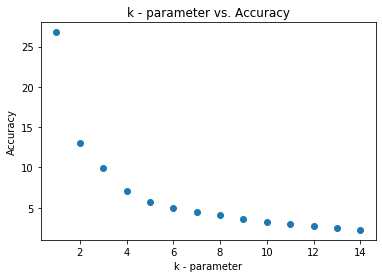

In [347]:
# Accuracy vs. k parameter characteristics plot
plt.scatter(calc_k['Accuracy'],calc_k['k'])
plt.title("k - parameter vs. Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("k - parameter")
plt.show

To choose optimal k parameter, it's recommended to select such a value where  k characteristic sharply shifts (elbow point). From diagram above, it's possible to see that elbow point lies where k parameter is 5 or 6. Based on trials where clustered data was processed with k=5 and k=6 it was concluded, that for further interpretation is more suitable to continue with k=6.
Cluster labels will be then merged with PragueDistricts_cl dataframe to obtain coordinates and cluster labels for each particular city district.

In [348]:
# set number of clusters
kclusters = 6

prague_combined_clustering = prague_combined.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(prague_combined_clustering)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels

array([2, 0, 1, 2, 1, 2, 4, 1, 2, 0, 1, 0, 0, 1, 0, 3, 3, 0, 0, 0, 0, 2,
       2, 0, 4, 0, 2, 0, 3, 1, 0, 1, 1, 0, 4, 1, 4, 2, 5, 0, 4, 4, 5, 1,
       3, 0, 5, 4, 0, 4, 0, 1, 0, 2, 1, 0, 0, 1, 4, 4, 3, 2, 0, 0, 2, 1,
       4, 4, 1, 0, 0, 4, 0, 0, 2, 0, 3, 5, 1, 2, 1, 4, 4, 1, 5, 0, 0, 2,
       4, 2, 1, 1, 3, 3, 2, 0, 5, 1, 0, 4, 0, 5, 1, 4, 0, 0, 0, 1, 2],
      dtype=int32)

In [349]:
# add clustering labels
prague_combined.insert(0, 'Cluster Labels', kmeans.labels_)

prague_merged = PragueDistricts_cl

# merging of dataframe PragueDistricts_cl with prague_merged to add latitude/longitude for each district and cluster label
prague_merged = prague_merged.join(prague_combined.set_index('District'), on='Prague District')

#find and drop NaN values
prague_merged = prague_merged.dropna()

#convert cluster labels to integers
prague_merged['Cluster Labels'] = prague_merged['Cluster Labels'].astype(int)

prague_merged

,Prague District,Latitude,Longitude,Cluster Labels,Gym,Metro Station,Park,Pharmacy,Train Station,Bus,Shopping
0,Stodůlky,50.048307,14.312404,5,0.166667,0.0,0.166667,0.000000,0.000000,0.500000,0.166667
1,Žižkov,50.081054,14.454917,2,0.333333,0.0,0.666667,0.000000,0.000000,0.000000,0.000000
2,Chodov,50.032843,14.501643,1,0.000000,0.0,0.375000,0.125000,0.000000,0.375000,0.125000
3,Vinohrady,50.075359,14.436394,2,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000
4,Vršovice,50.071885,14.472665,3,0.500000,0.0,0.500000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
106,Královice,50.038362,14.636171,4,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000
107,Lahovice,49.988587,14.397336,4,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000
108,Nedvězí u Říčan,50.016467,14.653807,4,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000
109,Lipany,49.999546,14.617539,4,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000


Now, let's visualize Prague districts with assigned color for each cluster. This step will be beneficial later for final results evaluation.

In [350]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(prague_merged['Latitude'], prague_merged['Longitude'], prague_merged['Prague District'], prague_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's also create dataframe where data is grouped by cluster labels. This shows normalized distribution of venues in each cluster which will be considered in final evaluation.

In [351]:
prague_index = prague_merged.groupby('Cluster Labels').mean() # grouping by cluster labels

prague_index

,Latitude,Longitude,Gym,Metro Station,Park,Pharmacy,Train Station,Bus,Shopping
Cluster Labels,,,,,,,,,
0,50.061790,14.472427,0.059263,0.008543,0.117207,0.035117,0.082642,0.690655,0.006572
1,50.082121,14.475778,0.048176,0.020186,0.401479,0.069429,0.043808,0.406657,0.010266
2,50.076431,14.427053,0.113027,0.000000,0.790888,0.025516,0.036765,0.033804,0.000000
3,50.083751,14.441024,0.654762,0.000000,0.267113,0.031250,0.000000,0.046875,0.000000
4,50.049923,14.479456,0.000000,0.000000,0.000000,0.000000,0.017196,0.973545,0.009259
5,50.059465,14.416096,0.057205,0.023810,0.064626,0.062771,0.020408,0.479901,0.291280


#### Clusters Examination

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster.

##### Cluster 0

In [352]:
prague_merged.loc[prague_merged['Cluster Labels'] == 0, prague_merged.columns[[0, 4] + list(range(5, prague_merged.shape[1]))]]

,Prague District,Gym,Metro Station,Park,Pharmacy,Train Station,Bus,Shopping
10,Modřany,0.100000,0.0,0.000000,0.100000,0.100000,0.700000,0.000000
15,Řepy,0.111111,0.0,0.111111,0.000000,0.000000,0.777778,0.000000
18,Háje,0.076923,0.0,0.153846,0.076923,0.000000,0.692308,0.000000
23,Kamýk 142 00,0.000000,0.0,0.200000,0.200000,0.000000,0.600000,0.000000
26,Hostivař,0.111111,0.0,0.111111,0.000000,0.111111,0.666667,0.000000
...,...,...,...,...,...,...,...,...
92,Pitkovice,0.000000,0.0,0.200000,0.000000,0.000000,0.800000,0.000000
94,Třeboradice,0.000000,0.0,0.250000,0.000000,0.000000,0.750000,0.000000
96,Sedlec 160 00,0.117647,0.0,0.058824,0.000000,0.058824,0.705882,0.058824
103,Sobín,0.000000,0.0,0.000000,0.000000,0.333333,0.666667,0.000000


##### Cluster 1

In [353]:
prague_merged.loc[prague_merged['Cluster Labels'] == 1, prague_merged.columns[[0, 4] + list(range(5, prague_merged.shape[1]))]]

,Prague District,Gym,Metro Station,Park,Pharmacy,Train Station,Bus,Shopping
2,Chodov,0.000000,0.000,0.375000,0.125000,0.000000,0.375000,0.125
6,Strašnice,0.125000,0.125,0.500000,0.000000,0.000000,0.250000,0.000
7,Záběhlice,0.166667,0.000,0.250000,0.083333,0.083333,0.416667,0.000
13,Kobylisy,0.000000,0.000,0.333333,0.222222,0.000000,0.444444,0.000
20,Hlubočepy,0.000000,0.000,0.625000,0.000000,0.000000,0.375000,0.000
...,...,...,...,...,...,...,...,...
77,Běchovice,0.000000,0.000,0.300000,0.000000,0.200000,0.500000,0.000
80,Dolní Počernice,0.000000,0.000,0.400000,0.000000,0.000000,0.600000,0.000
82,Štěrboholy,0.000000,0.000,0.333333,0.333333,0.000000,0.333333,0.000
86,Radlice,0.000000,0.125,0.375000,0.000000,0.000000,0.500000,0.000


##### Cluster 2

In [354]:
prague_merged.loc[prague_merged['Cluster Labels'] == 2, prague_merged.columns[[0, 4] + list(range(5, prague_merged.shape[1]))]]

,Prague District,Gym,Metro Station,Park,Pharmacy,Train Station,Bus,Shopping
1,Žižkov,0.333333,0.0,0.666667,0.0,0.0,0.00,0.0
3,Vinohrady,0.000000,0.0,1.000000,0.0,0.0,0.00,0.0
8,Smíchov,0.000000,0.0,1.000000,0.0,0.0,0.00,0.0
11,Nusle,0.222222,0.0,0.777778,0.0,0.0,0.00,0.0
12,Krč,0.000000,0.0,1.000000,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...
83,Vyšehrad,0.200000,0.0,0.800000,0.0,0.0,0.00,0.0
85,Hradčany,0.125000,0.0,0.875000,0.0,0.0,0.00,0.0
88,Hrdlořezy,0.000000,0.0,0.750000,0.0,0.0,0.25,0.0
93,Josefov,0.000000,0.0,1.000000,0.0,0.0,0.00,0.0


##### Cluster 3

In [355]:
prague_merged.loc[prague_merged['Cluster Labels'] == 3, prague_merged.columns[[0, 4] + list(range(5, prague_merged.shape[1]))]]

,Prague District,Gym,Metro Station,Park,Pharmacy,Train Station,Bus,Shopping
4,Vršovice,0.500000,0.0,0.500000,0.00,0.0,0.000,0.0
5,Holešovice,1.000000,0.0,0.000000,0.00,0.0,0.000,0.0
9,Libeň,0.571429,0.0,0.428571,0.00,0.0,0.000,0.0
14,Nové Město,1.000000,0.0,0.000000,0.00,0.0,0.000,0.0
29,Vysočany,0.500000,0.0,0.375000,0.00,0.0,0.125,0.0
39,Karlín,0.666667,0.0,0.333333,0.00,0.0,0.000,0.0
43,Staré Město,0.500000,0.0,0.500000,0.00,0.0,0.000,0.0
104,Holyně,0.500000,0.0,0.000000,0.25,0.0,0.250,0.0


##### Cluster 4

In [356]:
prague_merged.loc[prague_merged['Cluster Labels'] == 4, prague_merged.columns[[0, 4] + list(range(5, prague_merged.shape[1]))]]

,Prague District,Gym,Metro Station,Park,Pharmacy,Train Station,Bus,Shopping
52,Suchdol,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000
61,Písnice,0.0,0.0,0.0,0.0,0.0,0.833333,0.166667
66,Ďáblice,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000
70,Nebušice,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000
74,Újezd u Průhonic,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000
...,...,...,...,...,...,...,...,...
102,Hájek u Uhříněvsi,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000
106,Královice,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000
107,Lahovice,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000
108,Nedvězí u Říčan,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000


##### Cluster 5

In [357]:
prague_merged.loc[prague_merged['Cluster Labels'] == 5, prague_merged.columns[[0, 4] + list(range(5, prague_merged.shape[1]))]]

,Prague District,Gym,Metro Station,Park,Pharmacy,Train Station,Bus,Shopping
0,Stodůlky,0.166667,0.000000,0.166667,0.000000,0.000000,0.500000,0.166667
16,Černý Most,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000
24,Letňany,0.142857,0.000000,0.142857,0.000000,0.142857,0.428571,0.142857
42,Kunratice,0.000000,0.000000,0.000000,0.000000,0.000000,0.571429,0.428571
56,Libuš,0.000000,0.000000,0.142857,0.000000,0.000000,0.571429,0.285714
58,Zličín,0.090909,0.000000,0.000000,0.272727,0.000000,0.454545,0.181818
105,Třebonice,0.000000,0.166667,0.000000,0.166667,0.000000,0.333333,0.333333


#### Final Selection of the Locations

Final selection and filtering of the locations is done based on combination of observing cluster map, prague_index dataframe where data are grouped according cluster labels and lists of locations in clusters generated in section above. Those data are then placed against selection criteria defined at the beginning of the analysis.
When we have a look at prague_index dataframe, it's possible to notice that some of the clusters doesn't contains one or more venue categories at all. This would jeopardize fulfillment of defined conditions. In case of Prague city this is the case of cluster 3 and cluster 4. Therefore they're excluded from selection process.

Another selection criteria is related to mobility and availability of public transport. Preference is to select locations, where is possible to travel ideally by both bus and train. If this combination isn't possible to achieve, preferred transport is on train and therefore all locations without train station availability are excluded.

In [368]:
prague_final_locations = prague_merged[prague_merged['Cluster Labels'].isin([0, 1, 2, 5])]
indexDel = prague_final_locations[(prague_final_locations['Train Station'] == 0)].index
prague_final_locations = prague_final_locations.drop(indexDel)
prague_final_locations

,Prague District,Latitude,Longitude,Cluster Labels,Gym,Metro Station,Park,Pharmacy,Train Station,Bus,Shopping
7,Záběhlice,50.057282,14.501349,1,0.166667,0.0,0.250000,0.083333,0.083333,0.416667,0.000000
10,Modřany,50.009806,14.406989,0,0.100000,0.0,0.000000,0.100000,0.100000,0.700000,0.000000
19,Dejvice,50.102556,14.391797,2,0.250000,0.0,0.625000,0.000000,0.125000,0.000000,0.000000
24,Letňany,50.136969,14.514886,5,0.142857,0.0,0.142857,0.000000,0.142857,0.428571,0.142857
25,Braník,50.035728,14.412717,1,0.000000,0.0,0.400000,0.000000,0.300000,0.300000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
77,Běchovice,50.081210,14.616026,1,0.000000,0.0,0.300000,0.000000,0.200000,0.500000,0.000000
96,Sedlec 160 00,50.133703,14.391723,0,0.117647,0.0,0.058824,0.000000,0.058824,0.705882,0.058824
101,Benice,50.012960,14.604874,2,0.000000,0.0,0.500000,0.000000,0.500000,0.000000,0.000000
103,Sobín,50.065626,14.266559,0,0.000000,0.0,0.000000,0.000000,0.333333,0.666667,0.000000


In [369]:
# create map
map_clusters_final = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(prague_final_locations['Latitude'], prague_final_locations['Longitude'], prague_final_locations['Prague District'], prague_final_locations['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_final)
       
map_clusters_final

### 5.2 Sydney - New South Wales, Australia

#### Dataset Import and Modification

Instability issues has appeared when using Nominatim module. Therefore, load into pandas dataframes was divided into several .xlsx files where there was no more than 70 inner suburbs names.

In [208]:
SydneySuburbs_70 = pd.read_excel('sydney_suburbs_v02-70.xlsx') # read the 1st excel file
SydneySuburbs_140 = pd.read_excel('sydney_suburbs_v02-140.xlsx') # read the 2nd excel file
SydneySuburbs_210 = pd.read_excel('sydney_suburbs_v02-210.xlsx') # read the 3rd excel file
SydneySuburbs_280 = pd.read_excel('sydney_suburbs_v02-280.xlsx') # read the 4th excel file
SydneySuburbs_320 = pd.read_excel('sydney_suburbs_v02-320.xlsx') # read the 5th excel file

print('All files has been loaded!')

All files has been loaded!


In [209]:
SydneySuburbs_70["Postcode"] = SydneySuburbs_70["Postcode"].astype(str) # convert postcode to string value
SydneySuburbs_70["Address"]=SydneySuburbs_70["Sydney Suburb"]+", "+ SydneySuburbs_70["State"] +" "+ SydneySuburbs_70["Postcode"] +", "+ SydneySuburbs_70["Country"] # merge columns and add Address column

SydneySuburbs_140["Postcode"] = SydneySuburbs_140["Postcode"].astype(str) # convert postcode to string value
SydneySuburbs_140["Address"]=SydneySuburbs_140["Sydney Suburb"]+", "+ SydneySuburbs_140["State"] +" "+ SydneySuburbs_140["Postcode"] +", "+ SydneySuburbs_140["Country"] # merge columns and add Address column

SydneySuburbs_210["Postcode"] = SydneySuburbs_210["Postcode"].astype(str) # convert postcode to string value
SydneySuburbs_210["Address"]=SydneySuburbs_210["Sydney Suburb"]+", "+ SydneySuburbs_210["State"] +" "+ SydneySuburbs_210["Postcode"] +", "+ SydneySuburbs_210["Country"] # merge columns and add Address column

SydneySuburbs_280["Postcode"] = SydneySuburbs_280["Postcode"].astype(str) # convert postcode to string value
SydneySuburbs_280["Address"]=SydneySuburbs_280["Sydney Suburb"]+", "+ SydneySuburbs_280["State"] +" "+ SydneySuburbs_280["Postcode"] +", "+ SydneySuburbs_280["Country"] # merge columns and add Address column

SydneySuburbs_320["Postcode"] = SydneySuburbs_320["Postcode"].astype(str) # convert postcode to string value
SydneySuburbs_320["Address"]=SydneySuburbs_320["Sydney Suburb"]+", "+ SydneySuburbs_320["State"] +" "+ SydneySuburbs_320["Postcode"] +", "+ SydneySuburbs_320["Country"] # merge columns and add Address column

SydneySuburbs_70.head()

,Sydney Suburb,State,Postcode,Country,Address
0,Australia Square,New South Wales,1215,Australia,"Australia Square, New South Wales 1215, Australia"
1,Grosvenor Place,New South Wales,1220,Australia,"Grosvenor Place, New South Wales 1220, Australia"
2,Royal Exchange,New South Wales,1225,Australia,"Royal Exchange, New South Wales 1225, Australia"
3,Queen Victoria Building,New South Wales,1230,Australia,"Queen Victoria Building, New South Wales 1230,..."
4,Eastern Suburbs,New South Wales,1235,Australia,"Eastern Suburbs, New South Wales 1235, Australia"


#### Dataset Extension by Coordinates

In [210]:
nom=Nominatim()
SydneySuburbs_70["Coordinates"]=SydneySuburbs_70["Address"].apply(nom.geocode) # add cooridinates column
SydneySuburbs_70["Latitude"]=SydneySuburbs_70["Coordinates"].apply(lambda x: x.latitude if x !=None else None) # add latitude values column
SydneySuburbs_70["Longitude"]=SydneySuburbs_70["Coordinates"].apply(lambda x: x.longitude if x !=None else None) # add laongitude values column
SydneySuburbs_70.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  """Entry point for launching an IPython kernel.


,Sydney Suburb,State,Postcode,Country,Address,Coordinates,Latitude,Longitude
0,Australia Square,New South Wales,1215,Australia,"Australia Square, New South Wales 1215, Australia","(Australia Square, 264, George Street, Darling...",-33.864946,151.207793
1,Grosvenor Place,New South Wales,1220,Australia,"Grosvenor Place, New South Wales 1220, Australia","(Grosvenor Place, West Pennant Hills, Sydney, ...",-33.741295,151.034051
2,Royal Exchange,New South Wales,1225,Australia,"Royal Exchange, New South Wales 1225, Australia",None,NaN,NaN
3,Queen Victoria Building,New South Wales,1230,Australia,"Queen Victoria Building, New South Wales 1230,...","(Queen Victoria Building, 455, George Street, ...",-33.871435,151.206669
4,Eastern Suburbs,New South Wales,1235,Australia,"Eastern Suburbs, New South Wales 1235, Australia","(Eastern Suburbs Property Group, Dover Road, R...",-33.870260,151.270226


In [211]:
nom=Nominatim()
SydneySuburbs_140["Coordinates"]=SydneySuburbs_140["Address"].apply(nom.geocode) # add cooridinates column
SydneySuburbs_140["Latitude"]=SydneySuburbs_140["Coordinates"].apply(lambda x: x.latitude if x !=None else None) # add latitude values column
SydneySuburbs_140["Longitude"]=SydneySuburbs_140["Coordinates"].apply(lambda x: x.longitude if x !=None else None) # add laongitude values column
SydneySuburbs_140.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  """Entry point for launching an IPython kernel.


,Sydney Suburb,State,Postcode,Country,Address,Coordinates,Latitude,Longitude
0,Eastern Suburbs,New South Wales,2004,Australia,"Eastern Suburbs, New South Wales 2004, Australia","(Eastern Suburbs Memorial Park, Matraville, Ba...",-33.974209,151.231355
1,University Of sydney,New South Wales,2006,Australia,"University Of sydney, New South Wales 2006, Au...","(The University of Sydney, Knox Street, Chippe...",-33.888907,151.189434
2,Ultimo,New South Wales,2007,Australia,"Ultimo, New South Wales 2007, Australia","(Ultimo, Sydney, Council of the City of Sydney...",-33.879473,151.198435
3,"Chippendale, Darlington",New South Wales,2008,Australia,"Chippendale, Darlington, New South Wales 2008,...","(Chippendale, Cleveland Street nr Beaumont Str...",-33.888332,151.196521
4,Pyrmont,New South Wales,2009,Australia,"Pyrmont, New South Wales 2009, Australia","(Pyrmont, Sydney, Council of the City of Sydne...",-33.869214,151.192363


In [212]:
nom=Nominatim()
SydneySuburbs_210["Coordinates"]=SydneySuburbs_210["Address"].apply(nom.geocode) # add cooridinates column
SydneySuburbs_210["Latitude"]=SydneySuburbs_210["Coordinates"].apply(lambda x: x.latitude if x !=None else None) # add latitude values column
SydneySuburbs_210["Longitude"]=SydneySuburbs_210["Coordinates"].apply(lambda x: x.longitude if x !=None else None) # add laongitude values column
SydneySuburbs_210.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  """Entry point for launching an IPython kernel.


,Sydney Suburb,State,Postcode,Country,Address,Coordinates,Latitude,Longitude
0,Fairlight,New South Wales,2094,Australia,"Fairlight, New South Wales 2094, Australia","(Fairlight, Northern Beaches, Sydney, Northern...",-33.793879,151.274147
1,Manly,New South Wales,2095,Australia,"Manly, New South Wales 2095, Australia","(Manly, Northern Beaches, Sydney, Northern Bea...",-33.803850,151.290823
2,Queenscliff,New South Wales,2096,Australia,"Queenscliff, New South Wales 2096, Australia","(Queenscliff, Northern Beaches, Sydney, Northe...",-33.782392,151.285401
3,Beacon Hill,New South Wales,2100,Australia,"Beacon Hill, New South Wales 2100, Australia","(Beacon Hill, Northern Beaches, Sydney, Northe...",-33.751787,151.260083
4,Macquarie University,New South Wales,2109,Australia,"Macquarie University, New South Wales 2109, Au...","(Macquarie University Library, Macquarie Walk,...",-33.775688,151.113509


In [214]:
nom=Nominatim()
SydneySuburbs_280["Coordinates"]=SydneySuburbs_280["Address"].apply(nom.geocode) # add cooridinates column
SydneySuburbs_280["Latitude"]=SydneySuburbs_280["Coordinates"].apply(lambda x: x.latitude if x !=None else None) # add latitude values column
SydneySuburbs_280["Longitude"]=SydneySuburbs_280["Coordinates"].apply(lambda x: x.longitude if x !=None else None) # add laongitude values column
SydneySuburbs_280.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  """Entry point for launching an IPython kernel.


,Sydney Suburb,State,Postcode,Country,Address,Coordinates,Latitude,Longitude
0,Austral,New South Wales,2179,Australia,"Austral, New South Wales 2179, Australia","(Austral, Sydney, Liverpool City Council, New ...",-33.928267,150.808282
1,Chullora,New South Wales,2190,Australia,"Chullora, New South Wales 2190, Australia","(Chullora, Sydney, Canterbury-Bankstown Counci...",-33.892500,151.047778
2,Belfield,New South Wales,2191,Australia,"Belfield, New South Wales 2191, Australia","(Belfield, Sydney, Canterbury-Bankstown Counci...",-33.904516,151.086001
3,Belmore,New South Wales,2192,Australia,"Belmore, New South Wales 2192, Australia","(Belmore, Tobruck Avenue, Belmore, Sydney, Can...",-33.917196,151.088710
4,Ashbury,New South Wales,2193,Australia,"Ashbury, New South Wales 2193, Australia","(Ashbury, Sydney, Canterbury-Bankstown Council...",-33.900111,151.118072


In [215]:
nom=Nominatim()
SydneySuburbs_320["Coordinates"]=SydneySuburbs_320["Address"].apply(nom.geocode) # add cooridinates column
SydneySuburbs_320["Latitude"]=SydneySuburbs_320["Coordinates"].apply(lambda x: x.latitude if x !=None else None) # add latitude values column
SydneySuburbs_320["Longitude"]=SydneySuburbs_320["Coordinates"].apply(lambda x: x.longitude if x !=None else None) # add laongitude values column
SydneySuburbs_320.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  """Entry point for launching an IPython kernel.


,Sydney Suburb,State,Postcode,Country,Address,Coordinates,Latitude,Longitude
0,Douglas Park,New South Wales,2569,Australia,"Douglas Park, New South Wales 2569, Australia","(Douglas Park, Wollondilly Shire Council, New ...",-34.193652,150.706958
1,Camden,New South Wales,2570,Australia,"Camden, New South Wales 2570, Australia","(Camden, Sydney, Camden Council, New South Wal...",-34.053232,150.696170
2,Balmoral Village,New South Wales,2571,Australia,"Balmoral Village, New South Wales 2571, Australia","(Balmoral, Wingecarribee Shire Council, New So...",-34.301817,150.515000
3,Lakesland,New South Wales,2572,Australia,"Lakesland, New South Wales 2572, Australia","(Lakesland, Wollondilly Shire Council, New Sou...",-34.164765,150.534187
4,Tahmoor,New South Wales,2573,Australia,"Tahmoor, New South Wales 2573, Australia","(Tahmoor, Wollondilly Shire Council, New South...",-34.225365,150.590749


In this step, we're going to merge all inner suburbs datasets together and drop row which contains NaN values.

In [216]:
# merge dataframes
SydneySuburbs = pd.concat([SydneySuburbs_70, SydneySuburbs_140, SydneySuburbs_210, SydneySuburbs_280, SydneySuburbs_320], ignore_index=True)
SydneySuburbs.dropna(inplace=True)
SydneySuburbs

,Sydney Suburb,State,Postcode,Country,Address,Coordinates,Latitude,Longitude
0,Australia Square,New South Wales,1215,Australia,"Australia Square, New South Wales 1215, Australia","(Australia Square, 264, George Street, Darling...",-33.864946,151.207793
1,Grosvenor Place,New South Wales,1220,Australia,"Grosvenor Place, New South Wales 1220, Australia","(Grosvenor Place, West Pennant Hills, Sydney, ...",-33.741295,151.034051
3,Queen Victoria Building,New South Wales,1230,Australia,"Queen Victoria Building, New South Wales 1230,...","(Queen Victoria Building, 455, George Street, ...",-33.871435,151.206669
4,Eastern Suburbs,New South Wales,1235,Australia,"Eastern Suburbs, New South Wales 1235, Australia","(Eastern Suburbs Property Group, Dover Road, R...",-33.870260,151.270226
5,Haymarket,New South Wales,1240,Australia,"Haymarket, New South Wales 1240, Australia","(Haymarket, Sydney, Council of the City of Syd...",-33.881441,151.204452
...,...,...,...,...,...,...,...,...
311,Wentworth Falls,New South Wales,2782,Australia,"Wentworth Falls, New South Wales 2782, Australia","(Wentworth Falls, Sydney, Blue Mountains City ...",-33.715639,150.369759
312,Lawson,New South Wales,2783,Australia,"Lawson, New South Wales 2783, Australia","(Lawson, Sydney, Blue Mountains City Council, ...",-33.719448,150.431562
313,Bullaburra,New South Wales,2784,Australia,"Bullaburra, New South Wales 2784, Australia","(Bullaburra, Sydney, Blue Mountains City Counc...",-33.724860,150.413798
314,Blackheath,New South Wales,2785,Australia,"Blackheath, New South Wales 2785, Australia","(Blackheath, Shipley, Blue Mountains City Coun...",-33.633889,150.284722


In [328]:
SydneySuburbs_cl = SydneySuburbs.drop(["State", "Postcode", "Country", "Address", "Coordinates"], axis=1)
SydneySuburbs_cl

,Sydney Suburb,Latitude,Longitude
0,Australia Square,-33.864946,151.207793
1,Grosvenor Place,-33.741295,151.034051
3,Queen Victoria Building,-33.871435,151.206669
4,Eastern Suburbs,-33.870260,151.270226
5,Haymarket,-33.881441,151.204452
...,...,...,...
311,Wentworth Falls,-33.715639,150.369759
312,Lawson,-33.719448,150.431562
313,Bullaburra,-33.724860,150.413798
314,Blackheath,-33.633889,150.284722


#### Sydney Inner Suburbs Map Creation

In [311]:
syd_address = 'Sydney, New South Wales, Australia'

geolocator = Nominatim(user_agent="syd_explorer")
location = geolocator.geocode(syd_address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Sydney are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Sydney are -33.8548157, 151.2164539.


In the step of the map creation, radius size was extended from 1500m to 2000m for optimal coverage of the larger districts.

In [278]:
# create map of Sydney using latitude and longitude values
map_sydney = folium.Map(location=[latitude, longitude], zoom_start=10)

radius = 2000 # define radius

# add markers to map
for lat, lon, suburb, postcode in zip(SydneySuburbs['Latitude'], SydneySuburbs['Longitude'], SydneySuburbs['Sydney Suburb'], SydneySuburbs['Postcode']):
    label = '{}, {}'.format(suburb, postcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sydney)
    folium.Circle([lat, lon],
                    radius
                   ).add_to(map_sydney)
    
map_sydney

#### Venues Extraction via Fourquare API

In [220]:
LIMIT = 1000 # limit of number of venues returned by Foursquare API

def getNearbyVenues(names, latitudes, longitudes, radius=2000): # define radius of extraction
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [221]:
# return venues and merge with SydenySuburbs_cl dataframe
sydney_venues = getNearbyVenues(names=SydneySuburbs_cl['Sydney Suburb'],
                                   latitudes=SydneySuburbs_cl['Latitude'],
                                   longitudes=SydneySuburbs_cl['Longitude']
                                  )

Australia Square
Grosvenor Place
Queen Victoria Building
Eastern Suburbs
Haymarket
Darlinghurst
Potts Point
Woollahra
Waterloo
Alexandria
Camperdown
Botany
Mascot
University Of Nsw
Rockdale
West Chatswood
Frenchs Forest
North Ryde
Rydalmere
sydney
Penrith
Silverwater
Wetherill Park
Prestons
Milperra
Dawes Point
sydney
World Square
Eastern Suburbs
University Of sydney
Ultimo
Chippendale, Darlington
Pyrmont
Surry Hills
Woolloomooloo
Strawberry Hills
Alexandria, Beaconsfield
Redfern
Waterloo
Eastlakes
Banksmeadow
Mascot
Moore Park
Queens Park
Bellevue Hill
Bronte
Woollahra
Bondi
Darling Point
Double Bay
Rose Bay
Vaucluse
Clovelly
Daceyville
Kensington
Coogee
Maroubra
Chifley
Forest Lodge
Annandale
Rozelle
Leichhardt
Balmain
Enmore
Erskineville
St Peters
Haberfield
Abbotsford
Drummoyne
Stanmore
Lewisham
Camperdown
University Of New South Wales
Chatswood
North sydney
Waverton
Kirribilli
Cammeray
Northbridge
Artarmon
Crows Nest
Lane Cove
Chatswood
Middle Cove
Roseville
East Lindfield
Killara

In [222]:
# show the dataframe
sydney_venues

,District,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Australia Square,-33.864946,151.207793,Palmer & Co.,-33.864208,151.208340,Speakeasy
1,Australia Square,-33.864946,151.207793,Mr. Wong,-33.864113,151.207970,Chinese Restaurant
2,Australia Square,-33.864946,151.207793,Frankie's Pizza,-33.866013,151.209588,Pizza Place
3,Australia Square,-33.864946,151.207793,Bulletin Place,-33.862344,151.209339,Cocktail Bar
4,Australia Square,-33.864946,151.207793,1 Abercrombie Lane,-33.864039,151.207502,Bakery
...,...,...,...,...,...,...,...
13473,The Ponds,-33.706667,150.909167,EB Games,-33.719130,150.919640,Video Game Store
13474,The Ponds,-33.706667,150.909167,Tallawong Station,-33.691466,150.906480,Train Station
13475,The Ponds,-33.706667,150.909167,ALDI,-33.719473,150.919550,Supermarket
13476,The Ponds,-33.706667,150.909167,Noodle Hut,-33.719073,150.920508,Thai Restaurant


In [223]:
print('There are {} uniques categories.'.format(len(sydney_venues['Venue Category'].unique())))

There are 341 uniques categories.


In [233]:
# select defined venues and create new dataframe
syd_selected_venues = sydney_venues.loc[sydney_venues['Venue Category'].isin(['Gym','Fitness','Park','Bus','Bus Stop','Bus Station','Mall','Shopping Mall','Shopping Plaza','Metro','Metro Station', 'Metro Station and Buliding', 'Train','Train Station','Pharmacy',])]
syd_selected_venues

,District,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
39,Australia Square,-33.864946,151.207793,The Strand Arcade,-33.869420,151.207630,Shopping Mall
49,Australia Square,-33.864946,151.207793,Observatory Hill,-33.859125,151.204977,Park
59,Australia Square,-33.864946,151.207793,Virgin Active Health Club,-33.869680,151.208085,Gym
60,Australia Square,-33.864946,151.207793,Queen Victoria Building (QVB),-33.871521,151.206741,Shopping Mall
74,Australia Square,-33.864946,151.207793,The Domain,-33.867868,151.215370,Park
...,...,...,...,...,...,...,...
13460,The Ponds,-33.706667,150.909167,Kellyville Ridge,-33.702487,150.926464,Park
13461,The Ponds,-33.706667,150.909167,Stanhope Village,-33.718801,150.920046,Shopping Mall
13468,The Ponds,-33.706667,150.909167,Perfection Avenue Oval,-33.706725,150.924544,Park
13472,The Ponds,-33.706667,150.909167,Sydney Metro Tallawong Station,-33.691710,150.906020,Train Station


#### Data Preparation for Clustering

In [234]:
# one hot encoding
syd_onehot = pd.get_dummies(syd_selected_venues[['Venue Category']], prefix="", prefix_sep="")

# add suburb column back to dataframe
syd_onehot['District'] = syd_selected_venues['District'] 

# move suburb column to the first column
fixed_columns3 = [syd_onehot.columns[-1]] + list(syd_onehot.columns[:-1])
syd_onehot = syd_onehot[fixed_columns3]

# grouping according to Dictrict column and normalizing
syd_grouped = syd_onehot.groupby('District').mean().reset_index()
syd_grouped.head()

,District,Bus Station,Bus Stop,Gym,Park,Pharmacy,Shopping Mall,Shopping Plaza,Train Station
0,Abbotsbury,0.0,0.0,0.200000,0.600000,0.0,0.200000,0.0,0.0
1,Abbotsford,0.0,0.0,0.142857,0.857143,0.0,0.000000,0.0,0.0
2,Acacia Gardens,0.2,0.0,0.200000,0.200000,0.0,0.400000,0.0,0.0
3,Airds,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.0
4,Alexandria,0.0,0.0,0.000000,0.666667,0.0,0.333333,0.0,0.0


In [235]:
syd_combined = syd_grouped
syd_combined['Bus'] = syd_grouped['Bus Station'] + syd_grouped['Bus Stop'] # Bus category merging and adding of new the column to the dataframe
syd_combined['Shopping'] = syd_grouped['Shopping Mall'] + syd_grouped['Shopping Plaza']  # Shopping category merging and adding of new the column to the dataframe
syd_combined = syd_combined.drop(['Bus Station', 'Bus Stop', 'Shopping Mall', 'Shopping Plaza'], axis=1) # Deleting unnecessary columns
syd_combined.head()

,District,Gym,Park,Pharmacy,Train Station,Bus,Shopping
0,Abbotsbury,0.200000,0.600000,0.0,0.0,0.0,0.200000
1,Abbotsford,0.142857,0.857143,0.0,0.0,0.0,0.000000
2,Acacia Gardens,0.200000,0.200000,0.0,0.0,0.2,0.400000
3,Airds,0.000000,0.000000,0.0,0.0,0.0,1.000000
4,Alexandria,0.000000,0.666667,0.0,0.0,0.0,0.333333


#### K-Means Clustering

In [236]:
syd_combined_clustering = syd_combined.drop('District', 1)

calc_k = []
for k in range (1, 15):
 
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(syd_combined_clustering.iloc[:, :]) # K-Means model creation using k number from defined range.
    labels3 = kmeans_model.labels_ # labels fitting
    interia = kmeans_model.inertia_
    calc_k.append([k,interia])
    print ("k:",k, " accuracy:", interia)
calc_k = pd.DataFrame(calc_k)
calc_k.columns = ['Accuracy', 'k']
calc_k

k: 1  accuracy: 59.03431143495645
k: 2  accuracy: 38.427907021899784
k: 3  accuracy: 26.695938810713887
k: 4  accuracy: 22.185957634970016
k: 5  accuracy: 18.954179758895183
k: 6  accuracy: 16.149689521997935
k: 7  accuracy: 13.793765360069031
k: 8  accuracy: 12.171560668833525
k: 9  accuracy: 11.029204319582444
k: 10  accuracy: 10.132596209245126
k: 11  accuracy: 9.429631615222783
k: 12  accuracy: 8.881538545374042
k: 13  accuracy: 8.113313417164996
k: 14  accuracy: 7.785158169643751


,Accuracy,k
0,1,59.034311
1,2,38.427907
2,3,26.695939
3,4,22.185958
4,5,18.954180
...,...,...
9,10,10.132596
10,11,9.429632
11,12,8.881539
12,13,8.113313


<function matplotlib.pyplot.show(*args, **kw)>

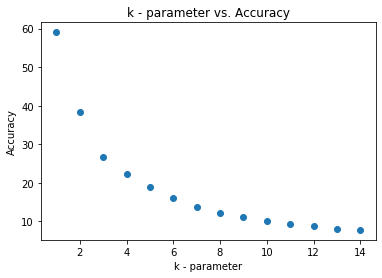

In [237]:
# Accuracy vs. k parameter characteristics plot
plt.scatter(calc_k['Accuracy'],calc_k['k'])
plt.title("k - parameter vs. Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("k - parameter")
plt.show

Based on above characteristic, as optimal value of the k was selected at k=6.

In [238]:
# set number of clusters
kclusters = 6

syd_combined_clustering = syd_combined.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(syd_combined_clustering)

# check cluster labels generated for each row in the dataframe
labels3 = kmeans.labels_
labels3

array([0, 2, 4, 4, 0, 0, 0, 4, 2, 3, 4, 5, 3, 5, 3, 4, 2, 1, 4, 4, 0, 2,
       5, 0, 5, 0, 4, 5, 4, 0, 3, 0, 5, 5, 3, 0, 4, 2, 4, 0, 5, 4, 0, 4,
       2, 2, 3, 1, 2, 0, 3, 2, 2, 2, 0, 5, 5, 3, 5, 4, 3, 5, 4, 5, 4, 0,
       2, 0, 0, 5, 0, 1, 4, 0, 5, 5, 0, 2, 5, 0, 5, 5, 2, 2, 2, 0, 5, 0,
       3, 2, 1, 2, 0, 5, 4, 3, 4, 2, 0, 1, 2, 4, 0, 3, 2, 0, 3, 0, 1, 5,
       2, 0, 5, 0, 0, 3, 3, 2, 4, 3, 0, 5, 4, 0, 0, 2, 0, 1, 4, 3, 0, 5,
       5, 3, 0, 3, 0, 2, 2, 3, 5, 1, 0, 0, 3, 1, 3, 0, 2, 4, 0, 0, 2, 1,
       1, 0, 0, 2, 3, 2, 3, 5, 2, 5, 4, 4, 0, 0, 5, 2, 3, 3, 0, 3, 0, 4,
       3, 2, 2, 3, 0, 2, 0, 0, 2, 0, 5, 2, 0, 2, 3, 3, 1, 2, 3, 4, 0, 0,
       4, 4, 2, 0, 0, 0, 0, 0, 0, 3, 3, 3, 5, 3, 0, 0, 0, 3, 2, 2, 0, 2,
       3, 0, 5, 4, 2, 0, 2, 5, 3, 0], dtype=int32)

In [239]:
# add clustering labels
syd_combined.insert(0, 'Cluster Labels', kmeans.labels_)

syd_merged = SydneySuburbs_cl

# merging of dataframe SydneySuburbs_cl with mlbrn_merged to add latitude/longitude for each suburb and cluster label
syd_merged = syd_merged.join(syd_combined.set_index('District'), on='Sydney Suburb')

#find and drop NaN values
syd_merged = syd_merged.dropna()

#conver cluster labels to integers
syd_merged['Cluster Labels'] = syd_merged['Cluster Labels'].astype(int)

syd_merged

,Sydney Suburb,Latitude,Longitude,Cluster Labels,Gym,Park,Pharmacy,Train Station,Bus,Shopping
0,Australia Square,-33.864946,151.207793,4,0.142857,0.428571,0.000000,0.000000,0.000000,0.428571
1,Grosvenor Place,-33.741295,151.034051,0,0.000000,0.571429,0.142857,0.000000,0.285714,0.000000
3,Queen Victoria Building,-33.871435,151.206669,0,0.166667,0.500000,0.000000,0.000000,0.000000,0.333333
4,Eastern Suburbs,-33.870260,151.270226,2,0.058824,0.764706,0.058824,0.000000,0.117647,0.000000
5,Haymarket,-33.881441,151.204452,0,0.200000,0.600000,0.000000,0.000000,0.000000,0.200000
...,...,...,...,...,...,...,...,...,...,...
311,Wentworth Falls,-33.715639,150.369759,3,0.000000,0.500000,0.000000,0.500000,0.000000,0.000000
312,Lawson,-33.719448,150.431562,1,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
313,Bullaburra,-33.724860,150.413798,3,0.000000,0.333333,0.000000,0.666667,0.000000,0.000000
314,Blackheath,-33.633889,150.284722,2,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000


In [240]:
# create map
syd_map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(syd_merged['Latitude'], syd_merged['Longitude'], syd_merged['Sydney Suburb'], syd_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(syd_map_clusters)
       
syd_map_clusters

In [241]:
syd_index = syd_merged.groupby('Cluster Labels').mean() # grouping by cluster labels
syd_index

,Latitude,Longitude,Gym,Park,Pharmacy,Train Station,Bus,Shopping
Cluster Labels,,,,,,,,
0,-33.872729,151.088578,0.205688,0.564646,0.025450,0.024970,0.042511,0.136735
1,-33.985676,150.722139,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
2,-33.872715,151.111127,0.050529,0.894269,0.007069,0.005102,0.025040,0.017991
3,-33.933321,150.970346,0.120506,0.278323,0.035516,0.414841,0.024722,0.126091
4,-33.853921,150.943679,0.104057,0.224470,0.043987,0.055816,0.040751,0.530919
5,-33.863833,150.955776,0.496814,0.131922,0.029630,0.062048,0.052414,0.227172


#### Clusters Examination

##### Cluster 0

In [242]:
syd_merged.loc[syd_merged['Cluster Labels'] == 0, syd_merged.columns[[0, 4] + list(range(5, syd_merged.shape[1]))]]

,Sydney Suburb,Gym,Park,Pharmacy,Train Station,Bus,Shopping
1,Grosvenor Place,0.000000,0.571429,0.142857,0.000000,0.285714,0.000000
3,Queen Victoria Building,0.166667,0.500000,0.000000,0.000000,0.000000,0.333333
5,Haymarket,0.200000,0.600000,0.000000,0.000000,0.000000,0.200000
12,Waterloo,0.142857,0.714286,0.000000,0.000000,0.000000,0.142857
13,Alexandria,0.000000,0.666667,0.000000,0.000000,0.000000,0.333333
...,...,...,...,...,...,...,...
225,Bardwell Park,0.166667,0.500000,0.000000,0.166667,0.166667,0.000000
226,Kingsgrove,0.250000,0.500000,0.000000,0.000000,0.000000,0.250000
227,Beverly Hills,0.142857,0.571429,0.000000,0.142857,0.142857,0.000000
236,Dolls Point,0.000000,0.500000,0.250000,0.000000,0.000000,0.250000


##### Cluster 1

In [243]:
syd_merged.loc[syd_merged['Cluster Labels'] == 1, syd_merged.columns[[0, 4] + list(range(5, syd_merged.shape[1]))]]

,Sydney Suburb,Gym,Park,Pharmacy,Train Station,Bus,Shopping
204,Edmondson Park,0.0,0.0,0.0,1.0,0.0,0.0
256,Coalcliff,0.0,0.0,0.0,1.0,0.0,0.0
257,Austinmer,0.0,0.0,0.0,1.0,0.0,0.0
258,Bulli,0.0,0.0,0.0,1.0,0.0,0.0
273,Menangle Park,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
298,Schofields,0.0,0.0,0.0,1.0,0.0,0.0
307,Faulconbridge,0.0,0.0,0.0,1.0,0.0,0.0
309,Linden,0.0,0.0,0.0,1.0,0.0,0.0
310,Hazelbrook,0.0,0.0,0.0,1.0,0.0,0.0


##### Cluster 2

In [244]:
syd_merged.loc[syd_merged['Cluster Labels'] == 2, syd_merged.columns[[0, 4] + list(range(5, syd_merged.shape[1]))]]

,Sydney Suburb,Gym,Park,Pharmacy,Train Station,Bus,Shopping
4,Eastern Suburbs,0.058824,0.764706,0.058824,0.0,0.117647,0.000000
6,Darlinghurst,0.000000,1.000000,0.000000,0.0,0.000000,0.000000
9,Woollahra,0.117647,0.764706,0.058824,0.0,0.000000,0.058824
17,Mascot,0.000000,1.000000,0.000000,0.0,0.000000,0.000000
61,Prestons,0.000000,1.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...
284,Glenmore Park,0.000000,1.000000,0.000000,0.0,0.000000,0.000000
285,Cambridge Park,0.000000,1.000000,0.000000,0.0,0.000000,0.000000
288,Emu Plains,0.000000,1.000000,0.000000,0.0,0.000000,0.000000
308,Hawkesbury Heights,0.000000,1.000000,0.000000,0.0,0.000000,0.000000


##### Cluster 3

In [245]:
syd_merged.loc[syd_merged['Cluster Labels'] == 3, syd_merged.columns[[0, 4] + list(range(5, syd_merged.shape[1]))]]

,Sydney Suburb,Gym,Park,Pharmacy,Train Station,Bus,Shopping
46,Rydalmere,0.222222,0.222222,0.0,0.444444,0.111111,0.000000
127,Killara,0.000000,0.400000,0.0,0.600000,0.000000,0.000000
128,Gordon,0.166667,0.333333,0.0,0.500000,0.000000,0.000000
129,Turramurra,0.250000,0.250000,0.0,0.500000,0.000000,0.000000
150,Rydalmere,0.222222,0.222222,0.0,0.444444,0.111111,0.000000
...,...,...,...,...,...,...,...
302,Doonside,0.000000,0.400000,0.2,0.200000,0.000000,0.200000
305,Glenbrook,0.000000,0.500000,0.0,0.500000,0.000000,0.000000
311,Wentworth Falls,0.000000,0.500000,0.0,0.500000,0.000000,0.000000
313,Bullaburra,0.000000,0.333333,0.0,0.666667,0.000000,0.000000


##### Cluster 4

In [246]:
syd_merged.loc[syd_merged['Cluster Labels'] == 4, syd_merged.columns[[0, 4] + list(range(5, syd_merged.shape[1]))]]

,Sydney Suburb,Gym,Park,Pharmacy,Train Station,Bus,Shopping
0,Australia Square,0.142857,0.428571,0.000000,0.000000,0.000000,0.428571
53,Penrith,0.333333,0.000000,0.000000,0.000000,0.000000,0.666667
97,Maroubra,0.181818,0.272727,0.090909,0.000000,0.181818,0.272727
126,East Lindfield,0.000000,0.400000,0.000000,0.200000,0.000000,0.400000
130,St Ives,0.000000,0.400000,0.000000,0.000000,0.000000,0.600000
...,...,...,...,...,...,...,...
292,North Richmond,0.000000,0.500000,0.000000,0.000000,0.000000,0.500000
295,St Clair,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
296,Colyton,0.000000,0.000000,0.000000,0.333333,0.000000,0.666667
299,Acacia Gardens,0.200000,0.200000,0.000000,0.000000,0.200000,0.400000


##### Cluster 5

In [247]:
syd_merged.loc[syd_merged['Cluster Labels'] == 5, syd_merged.columns[[0, 4] + list(range(5, syd_merged.shape[1]))]]

,Sydney Suburb,Gym,Park,Pharmacy,Train Station,Bus,Shopping
37,Frenchs Forest,0.333333,0.000000,0.000000,0.000000,0.333333,0.333333
59,Wetherill Park,0.500000,0.000000,0.000000,0.000000,0.000000,0.500000
68,World Square,0.333333,0.333333,0.000000,0.000000,0.000000,0.333333
94,Daceyville,0.500000,0.000000,0.000000,0.000000,0.000000,0.500000
114,Chatswood,0.428571,0.142857,0.000000,0.142857,0.000000,0.285714
...,...,...,...,...,...,...,...
252,Coniston,0.333333,0.000000,0.166667,0.166667,0.166667,0.166667
255,Berkeley,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
265,Figtree,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
269,Catherine Field,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Final Selection of the Locations

After clustering of locations of the Sydney It was find out that cluster 1 doesn't meet defined conditions in almost any category and due to that was excluded from further processing. As in the previous cases, the condition of preference for using public transport by train was applied here and therefore all locations without train station availability were excluded too.

In [306]:
syd_final_locations = syd_merged[syd_merged['Cluster Labels'].isin([0, 2, 3, 4, 5])]
indexDel3 = syd_final_locations[(syd_final_locations['Train Station'] == 0)].index
syd_final_locations = syd_final_locations.drop(indexDel3)
syd_final_locations

,Sydney Suburb,Latitude,Longitude,Cluster Labels,Gym,Park,Pharmacy,Train Station,Bus,Shopping
46,Rydalmere,-33.810017,151.029281,3,0.222222,0.222222,0.0,0.444444,0.111111,0.000000
114,Chatswood,-31.872494,147.500293,5,0.428571,0.142857,0.0,0.142857,0.000000,0.285714
120,Artarmon,-33.808955,151.185309,5,0.444444,0.111111,0.0,0.111111,0.000000,0.333333
123,Chatswood,-33.797481,151.180939,5,0.428571,0.142857,0.0,0.142857,0.000000,0.285714
125,Roseville,-33.782646,151.182726,0,0.250000,0.333333,0.0,0.166667,0.000000,0.250000
...,...,...,...,...,...,...,...,...,...,...
302,Doonside,-33.763689,150.869183,3,0.000000,0.400000,0.2,0.200000,0.000000,0.200000
305,Glenbrook,-33.767066,150.622492,3,0.000000,0.500000,0.0,0.500000,0.000000,0.000000
311,Wentworth Falls,-33.715639,150.369759,3,0.000000,0.500000,0.0,0.500000,0.000000,0.000000
313,Bullaburra,-33.724860,150.413798,3,0.000000,0.333333,0.0,0.666667,0.000000,0.000000


In [312]:
# create map
syd_map_clusters_final = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(syd_final_locations['Latitude'], syd_final_locations['Longitude'], syd_final_locations['Sydney Suburb'], syd_final_locations['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(syd_map_clusters_final)
       
syd_map_clusters_final

## 6. Results and Discussion <a name="results"></a>

Analyses performed in section 5 gives resulting number of locations selected according defined conditions.

In case of Prague, 112 districts were used as an input and after finishing of selection process, 27 locations has been evaluated with highest potential to meet all criteria. That's 24% of all analyzed districts. Visualization shows that the clusters has more or less circular shape which separates location of historical center and approaching up to outskirts. Most of the finally selected districts are impacted by this trend and therefore lies in the circular pattern too. It is also possible to see that most of them are located near outskirts and are shaped according to train corridors.

Sydney distribution of the clusters is different from Prague. There is no clear pattern which could reflect clusters distribution, however from the visualization of the finally selected inner suburbs is possible to claim, that most of them are located parallelly to coast but keeping certain distance from it. There is also significant distance from the outskirts from inland side. Minority of inner suburb remains at the outskirt shaped clearly according to train corridors. In total, 271 inner suburbs has been analyzed and 76 has been classified to meet the criteria, that's 28%.


## 7. Conclusion <a name="conclusion"></a>

Purpose of this project was to find similarly specified districts, suburbs or neighborhoods across two different cities. This might come handy when person needs to move from one to another city and wants to keep current lifestyle. Conditions were setup to maintain healthy lifestyle, minimize time necessary for routine activities like traveling to job or shopping and dedicate it more to fitness activities in gyms or parks or spend more time on cultural events.

According to specified conditions, in Prague it's possible to find 27 locations for further exploration. In Sydney this number is significantly higher - 76 locations. This is due to large loaded dataset containing inner suburbs. Ratios are however quite close 24% vs. 28%. This means that in Sydney are slightly higher chances to find those specified places. Situation will change if we decide to exclude locations without bus stops instead of locations without train station. After this, filtering return 87 location within Prague and 41 locations in Sydney. Ratios will be then 78% vs. 15%. This means that bus stops network is more denser in Prague than in Sydney.

Is it also worth to mention that resulting number of locations may vary according to precision of description of the venues obtained from Foursquare API. Some of them might be classified incorrectly like shopping malls and therefore there are unintentionally excluded.

Above presented result can be considered as starting point for deeper analysis of each location within clusters. With regard to that might appear new selection criteria like job location, traffic exploitation of the routes or location of the school for own kids. There might appear many other individual factors which could significantly reduce final number of suitable locations or find new one. This is however out of scope of this project. Despite, this analysis create solid base for further extension in described way.
